#TFM Juan Manuel Aguirre Cebrián

##Diagnóstico temprano de enfermedades cardiovasculares mediante aprendizaje profundo y análisis de imágenes.

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import nibabel as nib
# import torch
# import cv2
# import pydicom
# from pathlib import Path
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
#                              precision_score, recall_score, f1_score,
#                              accuracy_score, roc_auc_score, roc_curve)
# from google.colab import drive
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# import matplotlib.pyplot as plt
# import torchmetrics
# import torch.nn.functional as F
# from tqdm import tqdm

# SEED = 42
# pl.seed_everything(SEED)
# drive.mount('/content/drive')

# BASE_PATH = Path('/content/drive/MyDrive/datasets')
# ACDC_PATH = BASE_PATH / 'ACDC'
# SUNNY_PATH = BASE_PATH / 'Sunnybrook'
# BATCH_SIZE = 8
# EPOCHS = 100
# VOLUME_SHAPE = (16, 128, 128)
# NORMALIZATION_METHOD = 'percentile'

In [ ]:
import itertools
import os
import random
import re
from glob import glob
import matplotlib.pyplot as plt
import cv2
import h5py
import numpy as np
import torch
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler

from random import sample

/tmp/ipykernel_18/265319.py:12: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [ ]:
# def convertir_nifti_a_volumen():
#     for partition in ['training', 'testing']:
#         part_path = ACDC_PATH / partition
#         for patient_folder in sorted(part_path.glob('patient*')):
#             for nii_file in patient_folder.glob('*.nii.gz'):
#                 if '_gt' in nii_file.name:
#                     continue
#                 output_file = patient_folder / f"{nii_file.stem}_vol3d.npy"
#                 if output_file.exists():
#                     continue
#                 try:
#                     img = nib.load(str(nii_file)).get_fdata()
#                     volume = img[:, :, :, img.shape[3] // 2] if img.ndim == 4 else img
#                     volume = np.moveaxis(volume, -1, 0)
#                     resized_slices = [cv2.resize(slice, (VOLUME_SHAPE[2], VOLUME_SHAPE[1])) for slice in volume]
#                     volume = np.stack(resized_slices)
#                     if volume.shape[0] > VOLUME_SHAPE[0]:
#                         start = (volume.shape[0] - VOLUME_SHAPE[0]) // 2
#                         volume = volume[start:start + VOLUME_SHAPE[0]]
#                     else:
#                         pad = [(0, VOLUME_SHAPE[0] - volume.shape[0]), (0, 0), (0, 0)]
#                         volume = np.pad(volume, pad, mode='constant')
#                     if NORMALIZATION_METHOD == 'percentile':
#                         p1, p99 = np.percentile(volume, [1, 99])
#                         volume = np.clip((volume - p1) / (p99 - p1 + 1e-8), 0, 1)
#                     else:
#                         volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
#                     np.save(output_file, volume.astype(np.float32))
#                 except Exception as e:
#                     print(f"Error en {nii_file.name}: {e}")

In [ ]:
class ACDCDataset(Dataset):
    def __init__(self, base_dir=None, split='train', transform=None, fold="fold1", sup_type="label"):
        self._base_dir = base_dir
        self.sample_list = []
        self.split = split
        self.sup_type = sup_type
        self.transform = transform
        train_ids, test_ids = self._get_fold_ids(fold)
        if self.split == 'train':
            self.all_slices = os.listdir(
                self._base_dir + "/ACDC_training_slices")
            self.sample_list = []
            for ids in train_ids:
                new_data_list = list(filter(lambda x: re.match(
                    '{}.*'.format(ids), x) != None, self.all_slices))
                self.sample_list.extend(new_data_list)

        elif self.split == 'val':
            self.all_volumes = os.listdir(
                self._base_dir + "/ACDC_training_volumes")
            self.sample_list = []
            for ids in test_ids:
                new_data_list = list(filter(lambda x: re.match(
                    '{}.*'.format(ids), x) != None, self.all_volumes))
                self.sample_list.extend(new_data_list)

        print("total {} samples".format(len(self.sample_list)))

    def _get_fold_ids(self, fold):
        all_cases_set = ["patient{:0>3}".format(i) for i in range(1, 101)]
        fold1_testing_set = [
            "patient{:0>3}".format(i) for i in range(1, 21)]
        fold1_training_set = [
            i for i in all_cases_set if i not in fold1_testing_set]

        fold2_testing_set = [
            "patient{:0>3}".format(i) for i in range(21, 41)]
        fold2_training_set = [
            i for i in all_cases_set if i not in fold2_testing_set]

        fold3_testing_set = [
            "patient{:0>3}".format(i) for i in range(41, 61)]
        fold3_training_set = [
            i for i in all_cases_set if i not in fold3_testing_set]

        fold4_testing_set = [
            "patient{:0>3}".format(i) for i in range(61, 81)]
        fold4_training_set = [
            i for i in all_cases_set if i not in fold4_testing_set]

        fold5_testing_set = [
            "patient{:0>3}".format(i) for i in range(81, 101)]
        fold5_training_set = [
            i for i in all_cases_set if i not in fold5_testing_set]
        if fold == "fold1":
            return [fold1_training_set, fold1_testing_set]
        elif fold == "fold2":
            return [fold2_training_set, fold2_testing_set]
        elif fold == "fold3":
            return [fold3_training_set, fold3_testing_set]
        elif fold == "fold4":
            return [fold4_training_set, fold4_testing_set]
        elif fold == "fold5":
            return [fold5_training_set, fold5_testing_set]
        elif fold == "MAAGfold":
            training_set = ["patient{:0>3}".format(i) for i in [56, 97, 43, 14, 52, 61, 26, 31, 93, 6, 99, 88, 74, 53, 91, 45, 71, 69, 54, 28, 19, 38, 100, 90, 47, 37, 50, 89, 35, 59, 4, 98, 21, 62, 63, 35, 46]]
            validation_set = ["patient{:0>3}".format(i) for i in [84, 32, 27, 96, 17, 18, 57, 81, 79, 22, 1, 44, 49, 25, 95]]
            return [training_set, validation_set]
        elif fold == "MAAGfold70":
            training_set = ["patient{:0>3}".format(i) for i in [92, 33, 87, 47, 45, 83, 21, 52, 98, 34, 31, 86, 14, 54, 11, 40, 38, 28, 9, 67, 7, 91, 69, 13, 63, 12, 42, 19, 53, 55, 4, 35, 74, 100, 99, 6, 61, 56, 97, 29, 51, 94, 2, 26, 76, 65, 43, 70, 66, 59, 8, 85, 50, 71, 90, 88, 16, 75, 93, 62, 89, 23, 20, 87, 46, 58, 15, 68, 60, 55, 66, 47, 48]]
            validation_set = ["patient{:0>3}".format(i) for i in [84, 32, 27, 96, 17, 18, 57, 81, 79, 22, 1, 44, 49, 25, 95]]
            return [training_set, validation_set]
        elif "MAAGfold" in fold:
            training_num = int(fold[8:])
            training_set = sample(["patient{:0>3}".format(i) for i in [92, 33, 87, 47, 45, 83, 21, 52, 98, 34, 31, 86, 14, 54, 11, 40, 38, 28, 9, 67, 7, 91, 69, 13, 63, 12, 42, 19, 53, 55, 4, 35, 74, 100, 99, 6, 61, 56, 97, 29, 51, 94, 2, 26, 76, 65, 43, 70, 66, 59, 8, 85, 50, 71, 90, 88, 16, 75, 93, 62, 89, 23, 20, 87, 46, 58, 15, 68, 60, 55, 66, 47, 48]], training_num)
            print("total {} training samples: {}".format(training_num, training_set))
            validation_set = ["patient{:0>3}".format(i) for i in [84, 32, 27, 96, 17, 18, 57, 81, 79, 22, 1, 44, 49, 25, 95]]
            return [training_set, validation_set]
        else:
            return "ERROR KEY"

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        case = self.sample_list[idx]
        if self.split == "train":
            h5f = h5py.File(self._base_dir +
                            "/ACDC_training_slices/{}".format(case), 'r')
        else:
            h5f = h5py.File(self._base_dir +
                            "/ACDC_training_volumes/{}".format(case), 'r')
        image = h5f['image'][:]
        label = h5f['label'][:]
        gt = h5f['label'][:]
        sample = {'image': image, 'label': label, 'gt': gt}
        if self.split == "train":
            image = h5f['image'][:]
            if self.sup_type == "random_walker":
                label = pseudo_label_generator_acdc(image, h5f["scribble"][:])
            else:
                label = h5f[self.sup_type][:]
            sample = {'image': image, 'label': label, 'gt': gt}
            if self.transform is not None:
                sample = self.transform(sample)
        else:
            image = h5f['image'][:]
            label = h5f['label'][:]
            sample = {'image': image, 'label': label, 'gt': gt}
        sample["idx"] = idx
        return sample

## ACDC_training_slices

In [ ]:
# model.eval()
# preds, targets = [], []
# with torch.no_grad():
#     for x, y in test_dl:
#         logits = model(x)
#         preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
#         targets.extend(y.cpu().numpy())

# acc = accuracy_score(targets, preds)
# prec = precision_score(targets, preds, average='weighted')
# rec = recall_score(targets, preds, average='weighted')
# f1 = f1_score(targets, preds, average='weighted')

# print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")

# cm = confusion_matrix(targets, preds)
# ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(xticks_rotation=45, cmap='Blues')
# plt.title("Matriz de Confusión")
# plt.tight_layout()
# plt.show()

In [ ]:
acdc_train = ACDCDataset(
    base_dir="/kaggle/input/acdc-dataset/ACDC_preprocessed",
    split="train",
    transform=None,
    fold="MAAGfold",
    sup_type="scribble")

total 656 samples


In [ ]:
print(acdc_train[0]["image"].shape)
print(acdc_train[0]["label"].shape)
print(acdc_train[0]["gt"].shape)

(256, 216)
(256, 216)
(256, 216)


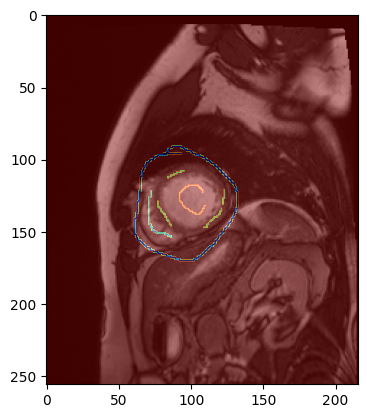

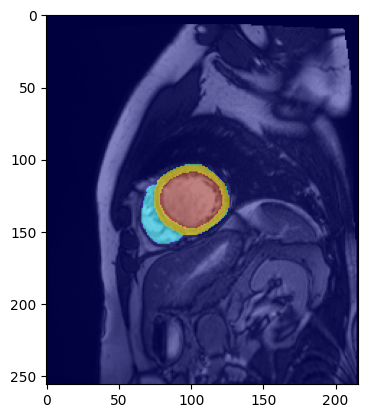

In [ ]:
idx = random.randint(0, len(acdc_train) - 1)
image = acdc_train[idx]['image']
label = acdc_train[idx]['label']
gt = acdc_train[idx]['gt']

plt.imshow(image, cmap='gray')

plt.imshow(label, cmap='jet', alpha=0.5)

plt.show()


plt.imshow(image, cmap='gray')

plt.imshow(gt, cmap='jet', alpha=0.5)

plt.show()

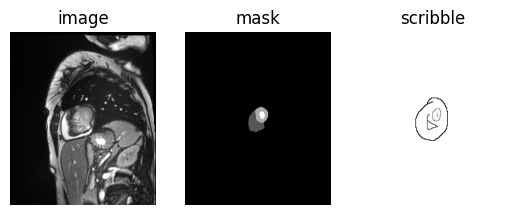

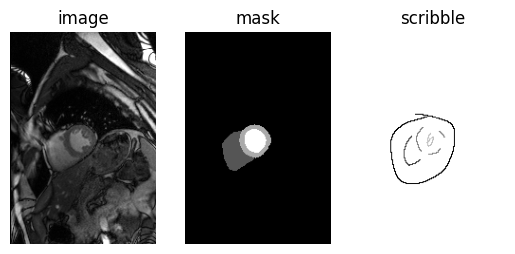

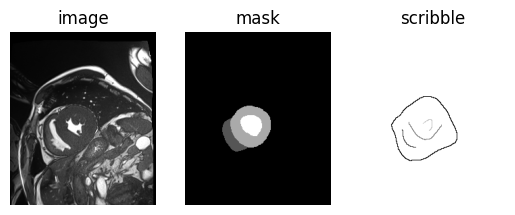

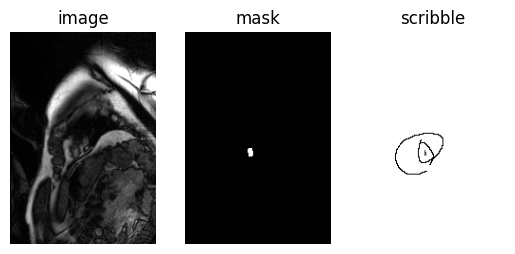

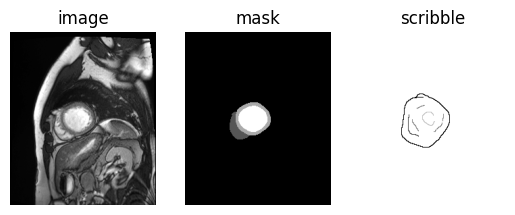

In [ ]:
for i in range(5):
    idx = random.randint(0, len(acdc_train) - 1)
    plt.subplot(1, 3,1)
    plt.imshow(acdc_train[idx]["image"], cmap="gray")
    plt.title("image")
    plt.axis("off")
    plt.subplot(1, 3,2)
    plt.imshow(acdc_train[idx]["gt"], cmap="gray")
    plt.title("mask")
    plt.axis("off")
    plt.subplot(1, 3,3)
    plt.imshow(acdc_train[idx]["label"], cmap="gray")
    plt.title("scribble")
    plt.axis("off")
    plt.show()

## ACDC_training_volumes and ACDC_testing volumes

In [ ]:
acdc_val = ACDCDataset(
    base_dir="/kaggle/input/acdc-dataset/ACDC_preprocessed",
    split="val",
    transform=None,
    fold="MAAGfold",
)

total 30 samples


In [ ]:
print(acdc_val[0]["image"].shape)
print(acdc_val[0]["label"].shape)

(12, 256, 208)
(12, 256, 208)


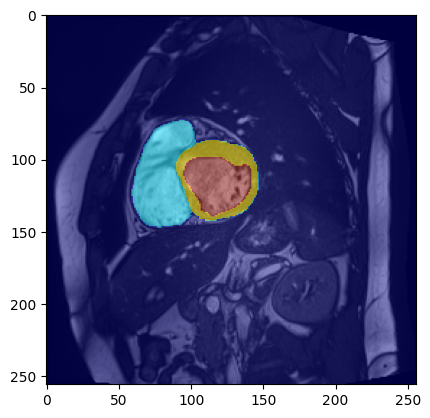

In [ ]:
idx = random.randint(0, len(acdc_val) - 1)
image = acdc_val[idx]['image'][0]
label = acdc_val[idx]['label'][0]

plt.imshow(image, cmap='gray')

plt.imshow(label, cmap='jet', alpha=0.5)

plt.show()